In [1]:
# 如何导入不同类型的图片
m = {"1":1, "2":"2"}
print(m)

{'1': 1, '2': '2'}


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from mmengine.model import BaseModel
from mmengine.evaluator import BaseMetric
from mmengine.registry import MODELS, DATASETS, METRICS


@MODELS.register_module()
class MyAwesomeModel(BaseModel):
    def __init__(self, layers=4, activation='relu') -> None:
        super().__init__()
        if activation == 'relu':
            act_type = nn.ReLU
        elif activation == 'silu':
            act_type = nn.SiLU
        elif activation == 'none':
            act_type = nn.Identity
        else:
            raise NotImplementedError
        sequence = [nn.Linear(2, 64), act_type()]
        for _ in range(layers-1):
            sequence.extend([nn.Linear(64, 64), act_type()])
        self.mlp = nn.Sequential(*sequence)
        self.classifier = nn.Linear(64, 2)

    def forward(self, data, labels, mode):
        x = self.mlp(data)
        x = self.classifier(x)
        if mode == 'tensor':
            return x
        elif mode == 'predict':
            return F.softmax(x, dim=1), labels
        elif mode == 'loss':
            return {'loss': F.cross_entropy(x, labels)}


@DATASETS.register_module()
class MyDataset(Dataset):
    def __init__(self, is_train, size):
        self.is_train = is_train
        if self.is_train:
            torch.manual_seed(0)
            self.labels = torch.randint(0, 2, (size,))
        else:
            torch.manual_seed(3407)
            self.labels = torch.randint(0, 2, (size,))
        r = 3 * (self.labels+1) + torch.randn(self.labels.shape)
        theta = torch.rand(self.labels.shape) * 2 * torch.pi
        self.data = torch.vstack([r*torch.cos(theta), r*torch.sin(theta)]).T

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)


@METRICS.register_module()
class Accuracy(BaseMetric):
    def __init__(self):
        super().__init__()

    def process(self, data_batch, data_samples):
        score, gt = data_samples
        self.results.append({
            'batch_size': len(gt),
            'correct': (score.argmax(dim=1) == gt).sum().cpu(),
        })

    def compute_metrics(self, results):
        total_correct = sum(r['correct'] for r in results)
        total_size = sum(r['batch_size'] for r in results)
        return dict(accuracy=100*total_correct/total_size)

ImportError: cannot import name 'ProcessGroup' from 'torch.distributed' (/Users/fanzhihao/anaconda3/envs/snake/lib/python3.8/site-packages/torch/distributed/__init__.py)

In [2]:
from torchvision import transforms
from PIL import Image

# 示例图像
img = Image.open("../../doc/jpg_exh/1692688072199.jpg")

# 定义一组转换操作
transformations = transforms.Compose([
    transforms.Resize((256, 256)),  # 调整大小
    transforms.RandomRotation(degrees=45),  # 随机旋转
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 的概率水平翻转
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 应用转换
transformed_img = transformations(img)

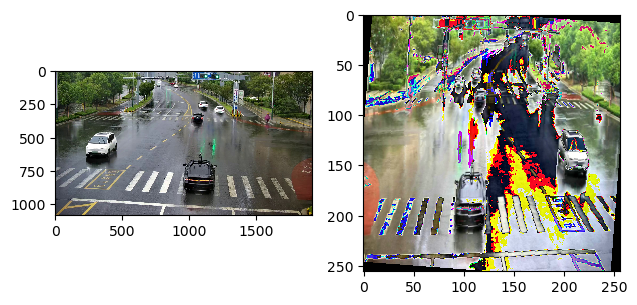

In [5]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

to_pil = ToPILImage()
pil_image = to_pil(transformed_img)

fig, axes = plt.subplots(1, 2)

axes[0].imshow(img)
axes[1].imshow(pil_image)

plt.tight_layout()

plt.show()